In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
from tqdm.notebook import trange

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
class VAE(nn.Module):
    def __init__(self, x_shape, z_dim, hidden_dim=500):
        super().__init__()
        
        self.x_shape = x_shape
        self.x_dim = np.prod(x_shape)
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(self.x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),   
        )

        self.stat_net = nn.Linear(hidden_dim, 
                                  2 * z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.x_dim),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(-1, self.x_dim)
        h = self.encoder(x)
        stats = self.stat_net(h)

        z_mu, z_logvar = torch.chunk(stats, 2, dim=-1)
        
        # reparameterization trick
    
        _std = (torch.randn_like(z_mu) 
                * torch.exp(0.5*z_logvar))
        z = z_mu + _std
        
        out = self.decoder(z)

        return out, z_mu, z_logvar
        

    def generate(self, z):
        return self.decoder(z).view(len(z), *self.x_shape)


In [4]:
def compute_elbo(x, x_reconst, mu, logvar):
    criterion = nn.BCELoss(reduction="sum")
    log_likelihood = -criterion(x_reconst, x.view(-1, 784))
    kl = -0.5 * torch.sum(1 + logvar -mu.pow(2) - logvar.exp())
    
    return log_likelihood - kl

In [5]:
z_dim = 2

n_epoch = 10
batch_size = 200
lr = 1e-3

device = torch.cuda.current_device()

dataset = datasets.MNIST('.', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
x_shape = (1, 28, 28)
vae = VAE(x_shape=x_shape, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [6]:
# essential code without log

for epoch_i in trange(n_epoch):
    for x, _ in loader:
        x = x.to(device)
        
        x_reconst, mu, logvar = vae(x)
        
        elbo = compute_elbo(x, x_reconst, mu, logvar)
        loss = -elbo
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
             

Text(0.5, 1.0, 'Learned z space')

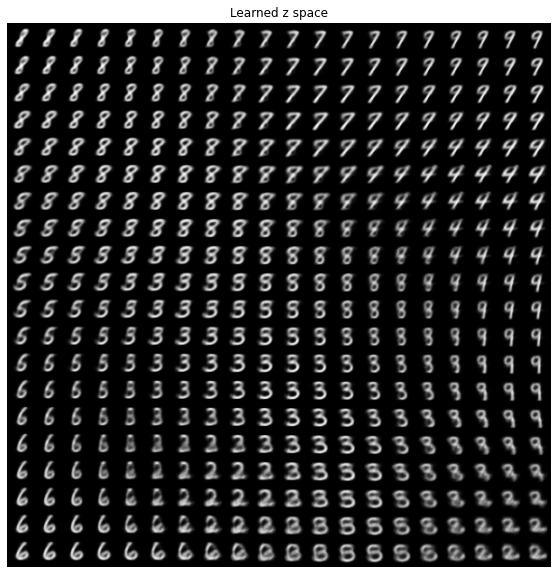

In [7]:
plt.figure(figsize=(10, 10))
z_range = np.arange(-1, 1, 0.1)
z_grid = np.stack(np.meshgrid(z_range, z_range), axis=-1)

z_grid_flat = z_grid.reshape(-1, 2)
zs = torch.tensor(z_grid_flat, dtype=torch.float).to(device)
x_reconst_flat = vae.generate(zs)
x_reconst = x_reconst_flat.detach().cpu().numpy().reshape(-1, *x_shape)

plt.imshow(np.transpose(
    vutils.make_grid(torch.tensor(x_reconst), padding=2, normalize=True, nrow=20).detach().cpu(),(1,2,0)
))
plt.axis('off')
plt.title('Learned z space')